In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import math 
import copy
from datetime import datetime   # useful for date ranges in plots
import os
os.chdir ('C:\\Users\\odiao\\Desktop\\Model Covid19\\programme_python\\SHR_PA\Code_Python')
os.getcwd ()

'C:\\Users\\odiao\\Desktop\\Model Covid19\\programme_python\\SHR_PA\\Code_Python'

In [2]:
sw_dataset = 'BEL'  # !! Default: 'BEL'. Currently 'BEL' and 'FRA' 'LUX'and 'UK'are available.
sw_districts = 'sum'  # !! Default: 'sum'. If 'sum', sums over all districts (i.e., provinces, departments...). If 'each', loop over all districts. sw_districts can also be the name of a district (for example, sw_districts = 'Brussels', or sw_districts = '75' for Paris).


In [3]:
# ***********************************************************************************
# Load data Belgium
#**********************************************************
if sw_dataset == 'BEL':   
    # The data comes from https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv.
    # This link was provided on 22 June 2020 by Alexey Medvedev on the "Re R0 estimation" channel of the O365G-covidata team on MS-Teams.
    # The link can be reached from https://epistat.wiv-isp.be/covid/
    # Some explanations can be found at https://epistat.sciensano.be/COVID19BE_codebook.pdf
    data_raw = pd.read_csv('Data/Belgium/COVID19BE_HOSP_2020-07-16.csv')
    #fields = ['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']
    if sw_districts == 'each':
        data_groupbydistrict = pd.DataFrame(data_raw.groupby("PROVINCE"))

In [4]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
confirmed_cases
data_end   = '7/15/20' #Take the data until yesterday
data_begin = '3/15/20'
cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == "Belgium", data_begin:data_end])[0]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


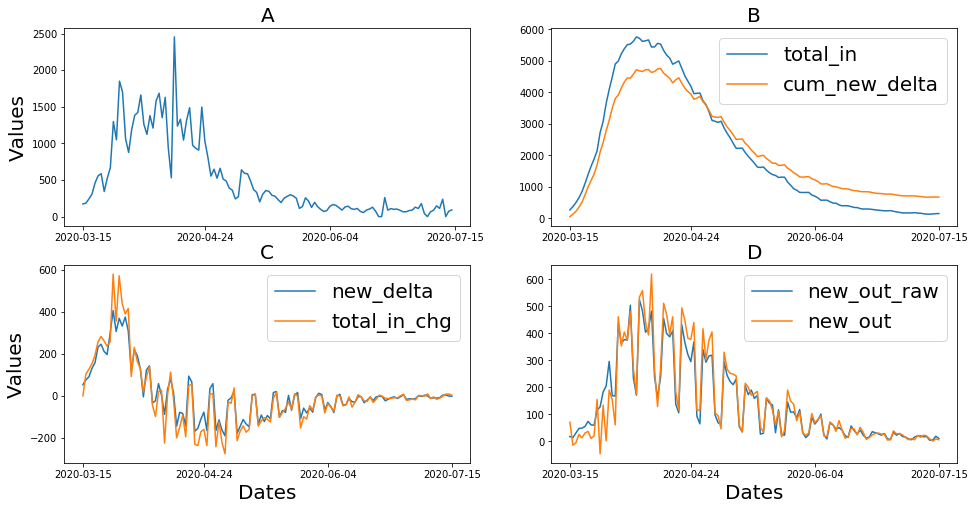

In [6]:
#*********************************
# Start loop on districts
# *******  
if sw_districts == 'sum':
    nb_districts = 1
elif sw_districts == 'each':
    nb_districts = len(data_groupbydistrict)
else:  # else nb_districts is the name of a district
    nb_districts = 1
    
if nb_districts > 2:
    show_figures = 0  # Force figures off if there are too many districts

for cnt_district in range(nb_districts):

    if sw_districts == 'sum':
        district_name = 'sum'
        district_names = np.array(['sum'])   # without np.array, we get an error in district_names[medians_argsort]
    elif sw_districts == 'each':
        district_name = data_groupbydistrict[0][cnt_district]
        district_names = data_groupbydistrict[0]
    else:
        district_name = sw_districts
        district_names = np.array([sw_districts]) 
    # ***********************************************************************************
    # Process data Belgium
    # *******
    if sw_dataset == 'BEL':

        if sw_districts == 'sum':
            data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces
        elif sw_districts == 'each':
            data_raw_district = data_groupbydistrict[1][cnt_district]  # extract province cnt_district
        else:   
            data_raw_district = data_raw[data_raw.iloc[:,1]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

        data = data_raw_district[['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']]  # exclude some useless columns

        # Extract relevant data and recompute new_out:
        # Source: Some variable names taken from https://rpubs.com/JMBodart/Covid19-hosp-be
        data_length = np.size(data,0)
        data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data['DATE'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 1
        col_new_in = 5
        col_new_out = 6
        total_in = data_num[:,col_total_in]
        new_in = data_num[:,col_new_in]
        new_out_raw = data_num[:,col_new_out] # there will be a non-raw due to the "Problem" mentioned below.
        new_delta = new_in - new_out_raw
        cum_new_delta = np.cumsum(new_delta)
        total_in_chg = np.hstack(([0],np.diff(total_in))) #difference between x[i+1]-x[i]
        # Problem: new_delta and total_in_chg are different, though they are sometimes close. 
        # Cum_new_delta does not go back to something close to zero, whereas it should. Hence I should not trust it.
        # I'm going to trust total_in and new_in. I deduce new_out_fixed by:
        new_out = new_in - total_in_chg   # fixed new_out
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns
        reported_cases = data_num[:,0]

        # Show Belgian data in figures:
        nb_xticks = 4
        dates_ticks = [None] * nb_xticks
        dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
        for i in range(0,nb_xticks):
            dates_ticks[i] = dates[dates_ticks_ind[i]]
        fig=plt.figure(figsize=(16,8))

        plt.subplot(2,2,1)
        plt.plot(dates[:len(np.diff(cases_obs))], np.diff(cases_obs))
        #plt.xlabel("Dates")
        plt.ylabel("Values", fontsize=20)
        plt.xticks(dates_ticks)
        #plt.legend()
        plt.title("A", fontsize=20)

        plt.subplot(2,2,2)
        plt.plot(dates, total_in)
        plt.plot(dates,cum_new_delta)
        #plt.xlabel("Dates")
        #plt.ylabel("Values", fontsize=20)
        plt.xticks(dates_ticks)
        plt.legend(("total_in","cum_new_delta"), fontsize=20)
        plt.title("B", fontsize=20)
        #plt.ylim([0,1000])

        plt.subplot(2,2,3)
        plt.plot(dates,new_delta)
        plt.plot(dates,total_in_chg)
        plt.xlabel("Dates", fontsize=20)
        plt.ylabel("Values", fontsize=20)
        plt.title("C", fontsize=20)
        plt.xticks(dates_ticks)
        plt.legend(("new_delta","total_in_chg"), fontsize=20)

        plt.subplot(2,2,4)
        plt.plot(dates,new_out_raw)
        plt.plot(dates,new_out)
        plt.xticks(dates_ticks)
        plt.xlabel("Dates", fontsize=20)
        plt.title("D", fontsize=20)
        plt.legend(("new_out_raw","new_out"), fontsize=20)
        plt.show()